In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['',
 'him that must be the enemys camp',
 'force upon kutuzovs line of communication with the troops that were',
 'he added rising you know my name and where to find me but dont',
 'theyll be announcing that the gentlemen are in the drawing room and we',
 'that number because fortythree was the sum of his and sonyas joint',
 '',
 '',
 'pace',
 'petersburg and had been expelled from there for riotous conduct and']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 0.4177,  1.2086, -0.4133,  ...,  1.6013, -0.5818, -1.2626],
        [ 1.4488,  1.0657, -0.3141,  ...,  1.1716, -0.0055,  0.5809],
        [-1.2951,  1.4652,  1.0294,  ...,  0.4753,  0.5367, -0.4322],
        ...,
        [-1.0873, -1.1517,  1.8077,  ...,  1.2739,  1.4068, -0.7720],
        [-1.7787,  2.0838, -0.0054,  ...,  0.7648,  0.5228,  1.4165],
        [ 0.2754,  1.2943,  1.2325,  ...,  1.9245, -1.4253,  1.2713]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 

In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2531494610.py line 8 
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 10:06:40.577000 133310579828544 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 constrained me innocent crack decent vehicle blackguards ride parodying space content sweet freely overcoats equality consequence period table goodhearted plunging musical grenadier focused official race diplomatista portfolio beard entreat effrontery zen leathergloved intonation doubts bull bellowitz coarse stage morally amazingly occasioned plait twos katies mate selfabnegation somewhere harnessing morio offend perturbed flexibly subtle deathlike buttons somberly lied population encounter tafa sponsor infected tres outbuildings where redness malign luggage regretting lovely battalion cet varied prime des theyll intending pure demanded fail arrived whois les laborerthats exposed purses humiliation laced announce memories unkind unharnessed silk distractions bayonets ferry truer merit readjusted indulged
 exploits alliee flaring implied here devoured effect voicewhich assumption singlehanded allowing serfs sly ages shitova accrue wasdid zherkovs smoke feather serfsthe suffering replie

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

len(stoi)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([1024, 512])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


11189

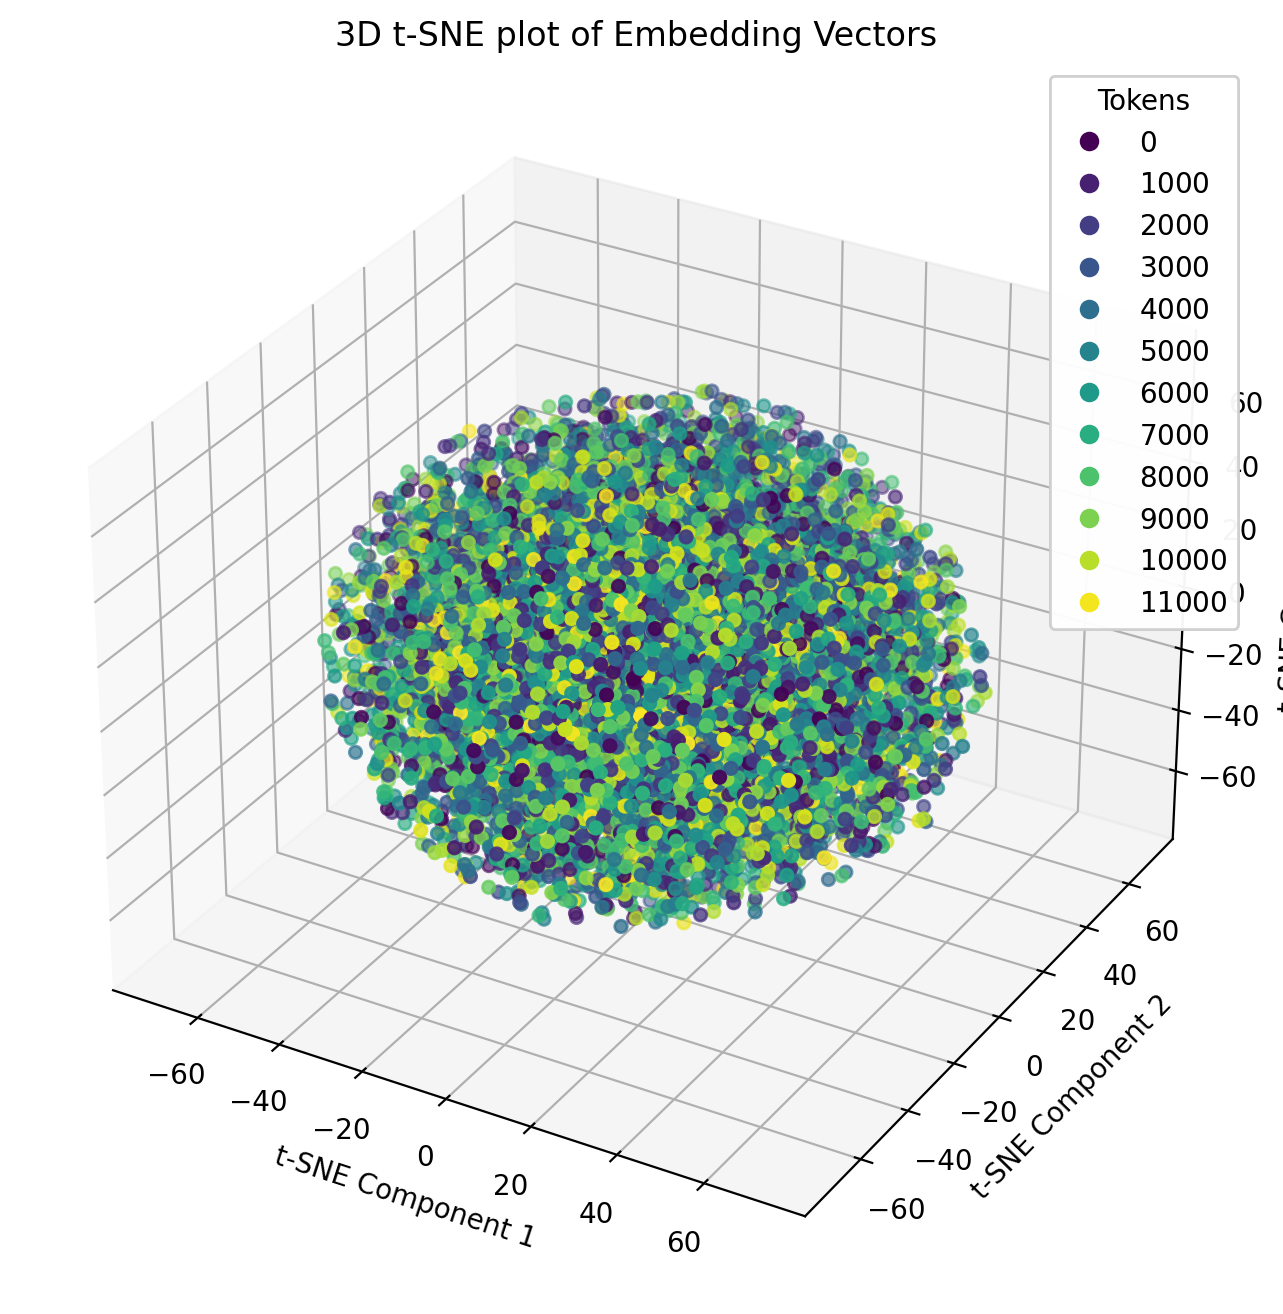

In [15]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [16]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass

Epoch 0, Loss: 13.10841178894043
Epoch 10, Loss: 10.35660171508789
Epoch 20, Loss: 9.385984420776367
Epoch 30, Loss: 8.719361305236816
Epoch 40, Loss: 8.180238723754883
Epoch 50, Loss: 7.70611572265625
Epoch 60, Loss: 7.275285720825195
Epoch 70, Loss: 6.879910469055176
Epoch 80, Loss: 6.517813682556152
Epoch 90, Loss: 6.189496040344238
Epoch 100, Loss: 5.894686222076416
Epoch 110, Loss: 5.631509780883789
Epoch 120, Loss: 5.396430969238281
Epoch 130, Loss: 5.185302734375
Epoch 140, Loss: 4.9945831298828125
Epoch 150, Loss: 4.821314334869385
Epoch 160, Loss: 4.663405895233154
Epoch 170, Loss: 4.518894672393799
Epoch 180, Loss: 4.386321067810059
Epoch 190, Loss: 4.264256000518799
Epoch 200, Loss: 4.151612758636475
Epoch 210, Loss: 4.047547817230225
Epoch 220, Loss: 3.9512553215026855
Epoch 230, Loss: 3.8620765209198
Epoch 240, Loss: 3.7793829441070557
Epoch 250, Loss: 3.7026243209838867
Epoch 260, Loss: 3.631228446960449
Epoch 270, Loss: 3.564785957336426
Epoch 280, Loss: 3.50294494628906

In [17]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 amid the army yes i have not be princess it to
 face that their commander was nicknamed by an sister we are
 and without holding his eyes for such than and took it
 
 
 caught settled and prince andrew smiled from the cold they
 not play the hussar he bent but he
 fellow all these yet brought into a letter and at five
 pick mon cher said he quoting sigh to the weaker and
 


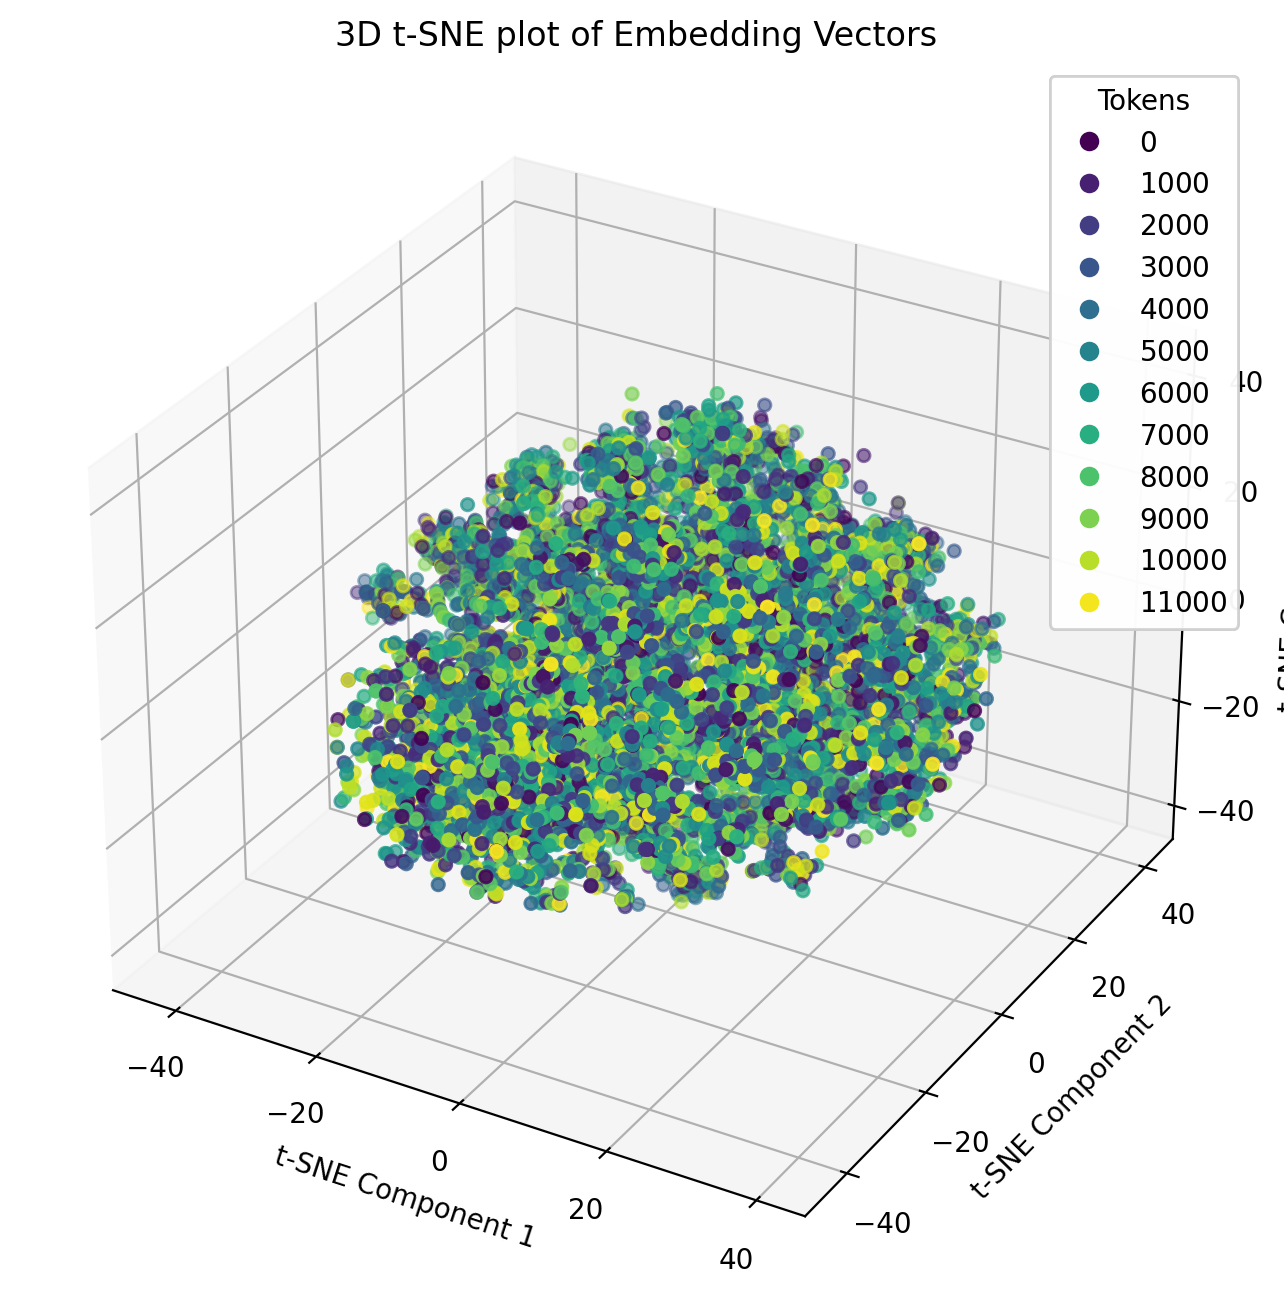

In [18]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [19]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_64_1024_t.pth")

In [20]:
model = model.to(device)